In [95]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
import seaborn as sn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical
from IPython.display import clear_output
from PIL import ImageFont
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

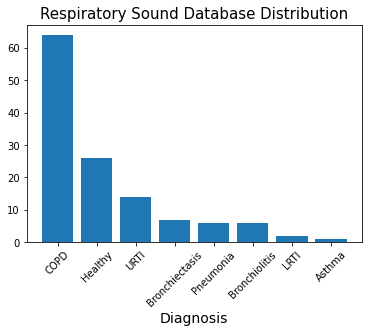

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: diagnosis, dtype: int64


In [9]:
#Data Sampling
patient_diagnosis = pd.read_csv(os.getcwd()+"\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\"+r'patient_diagnosis.csv', header=None)
patient_diagnosis.columns = ['patient_num','diagnosis']

plt.bar(patient_diagnosis['diagnosis'].value_counts().index, patient_diagnosis['diagnosis'].value_counts())
plt.title('Respiratory Sound Database Distribution', fontsize=15)
plt.xlabel('Diagnosis', fontsize=14)
plt.xticks(rotation=45)
plt.show()
print(patient_diagnosis['diagnosis'].value_counts())

In [10]:
#Get WAV_File and associate diagnosis and patient number
patient_audio_diagnosis = []
diagnosis_num = {"COPD": 0, "Healthy": 1, "URTI": 2, "Bronchiectasis": 3, "Pneumonia": 4, "Bronchiolitis": 5,
                "LRTI": 6, "Asthma": 7}
avoid_diag = [diagnosis_num['Asthma'], diagnosis_num['LRTI']]
for file in os.listdir('Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files'):
    if file.endswith('.wav'):
        patient_num = file.split('_')[0]
        audio_path = os.getcwd()+'\\Respiratory_Sound_Database\\Respiratory_Sound_Database\\audio_and_txt_files\\'+file
        patient_diag = diagnosis_num[patient_diagnosis.loc[patient_diagnosis['patient_num']==int(patient_num), 
                                                           'diagnosis'].iloc[0]]
        #Don't include avoid_diagnosis
        if patient_diag in avoid_diag:
            continue
        patient_audio_diagnosis.append({'patient_num':patient_num, 'audio_path': audio_path, 'patient_diag': patient_diag})

In [11]:
#Feature Extraction for sound files
def extract_features(file_path):
    sound, sample_rate = librosa.load(file_path)
    stft = np.abs(librosa.stft(sound))  
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    return np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

In [12]:
# Creation of images and their labels
images = []
labels = []
currTotal = 0
totalLabels = len(patient_audio_diagnosis)
for file in patient_audio_diagnosis:
    currTotal +=1
    images.append(extract_features(file['audio_path']))
    labels.append(file['patient_diag'])
    clear_output(wait=True)
    print(f"{currTotal} of {totalLabels}")
    


917 of 917


In [97]:
#Split dataset from training to test
labels = np.array(labels)
images = np.array(images)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=5)

#Encode Labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


y_train = np.reshape(y_train, (y_train.shape[0], 6))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 6))
x_test = np.reshape(x_test, (x_test.shape[0], x_train.shape[1],  1))

In [98]:
#Model Creation
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=70, batch_size=128, verbose=1)

Epoch 1/70
6/6 [==============================] - 1s 116ms/step - loss: 5.4088 - accuracy: 0.7299 - val_loss: 1.1656 - val_accuracy: 0.6793
Epoch 2/70
6/6 [==============================] - 1s 97ms/step - loss: 1.6802 - accuracy: 0.6726 - val_loss: 0.7919 - val_accuracy: 0.8859
Epoch 3/70
6/6 [==============================] - 1s 100ms/step - loss: 1.0684 - accuracy: 0.8595 - val_loss: 0.5545 - val_accuracy: 0.8859
Epoch 4/70
6/6 [==============================] - 1s 98ms/step - loss: 0.6818 - accuracy: 0.8445 - val_loss: 0.4390 - val_accuracy: 0.8859
Epoch 5/70
6/6 [==============================] - 1s 99ms/step - loss: 0.5763 - accuracy: 0.8486 - val_loss: 0.4019 - val_accuracy: 0.8859
Epoch 6/70
6/6 [==============================] - 1s 103ms/step - loss: 0.5470 - accuracy: 0.8581 - val_loss: 0.3911 - val_accuracy: 0.8859
Epoch 7/70
6/6 [==============================] - 1s 100ms/step - loss: 0.4890 - accuracy: 0.8595 - val_loss: 0.3699 - val_accuracy: 0.8859
Epoch 8/70
6/6 [=======

6/6 [==============================] - 1s 98ms/step - loss: 0.0559 - accuracy: 0.9836 - val_loss: 0.1683 - val_accuracy: 0.9457
Epoch 60/70
6/6 [==============================] - 1s 101ms/step - loss: 0.0664 - accuracy: 0.9754 - val_loss: 0.1525 - val_accuracy: 0.9511
Epoch 61/70
6/6 [==============================] - 1s 101ms/step - loss: 0.0486 - accuracy: 0.9836 - val_loss: 0.1866 - val_accuracy: 0.9348
Epoch 62/70
6/6 [==============================] - 1s 95ms/step - loss: 0.0452 - accuracy: 0.9836 - val_loss: 0.1644 - val_accuracy: 0.9457
Epoch 63/70
6/6 [==============================] - 1s 101ms/step - loss: 0.0360 - accuracy: 0.9918 - val_loss: 0.1620 - val_accuracy: 0.9565
Epoch 64/70
6/6 [==============================] - 1s 100ms/step - loss: 0.0344 - accuracy: 0.9891 - val_loss: 0.1741 - val_accuracy: 0.9457
Epoch 65/70
6/6 [==============================] - 1s 96ms/step - loss: 0.0319 - accuracy: 0.9864 - val_loss: 0.2038 - val_accuracy: 0.9457
Epoch 66/70
6/6 [===========

In [99]:
score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print(score)

[0.18289490044116974, 0.9510869383811951]


6/6 [==============================] - 0s 8ms/step
                precision    recall  f1-score   support

          COPD       0.97      0.99      0.98       163
       Healthy       0.86      0.86      0.86         7
          URTI       0.33      0.33      0.33         3
Bronchiectasis       1.00      1.00      1.00         2
     Pneumonia       0.75      0.43      0.55         7
 Bronchiolitis       1.00      0.50      0.67         2

      accuracy                           0.95       184
     macro avg       0.82      0.69      0.73       184
  weighted avg       0.95      0.95      0.95       184



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

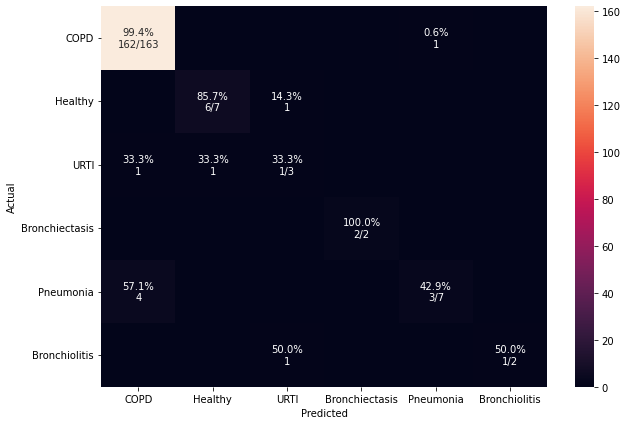

In [101]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]

preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')